# Assignment 6 - Object recognition in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get to use the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors and automatic differentiation
 * layered models
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that it is running a process (pid=10843) that currently takes up close to 3 GB of GPU memory. On our current `blu9402` lab machines you will notice a difference, as they have 8GB of RAM.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

To build deep learning models in this assignment we are using **[PyTorch](http://pytorch.org)**, a replacement for numpy that provides accelerated computation on the GPU, automatic differentiation, and various utilities to train and deploy neural networks. Its popularity relative to [tensorflow](http://tensorflow.org) has been steadily increasing and it also has a high-level API, the [NN module](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) similar to [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras).

In case you have trouble configuring a conda environment that has a CUDA version of pytorch installed, you could use the one that's provided under the prefix  
`conda activate /usr/shared/CMPT/big-data/condaenv/gt`

### Save disk space in the lab: Use shared downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.9G):
```
mkdir -p ~/.cache/torch/hub/checkpoints
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/checkpoints/* ~/.cache/torch/hub/checkpoints
```

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) on Tensors, or the NN module, or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice [**blog-post** by Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

To familiarize yourself with using pytorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html). The following code is preparing our training setup.

In [25]:
# to check GPU memory, uncomment and run the following line
!{'nvidia-smi'}

Thu Feb 23 06:17:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   4850MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The training data consists of $50,000$ example images.  
`imgs` is an array of shape (50000, 8, 8), giving an $8\times8$ pixel image for each example.  
`bboxes` is an array of shape (50000, 1, 4), giving a $1\times4$ row vector [x, y, w, h] for each rectangle.

**Here is an example of the training data:**

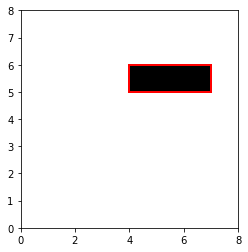

In [26]:
from IPython.display import display,Markdown
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]

display(Markdown(f"The training data consists of ${num_imgs:,}$ example images.  \n"
                 f"`imgs` is an array of shape {imgs.shape}, giving an ${img_size}\\times{img_size}$ pixel image for each example.  \n"
                 f"`bboxes` is an array of shape {bboxes.shape}, giving a $1\\times4$ row vector [x, y, w, h] for each rectangle."
                ))
display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none', lw=2))

In [27]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
display(Markdown(f"New shape of `imgs`: {X.shape}, with normalized mean {np.mean(X):.2f} and stdev {np.std(X):.2f}"))

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

New shape of `imgs`: (50000, 64), with normalized mean 0.00 and stdev 1.00

## Task 1a
**Construct a Pytorch model that resembles the Keras one in the original blog post**, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc_layer1 = nn.Linear(64, 200)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc_layer2 = nn.Linear(200, 4)

    def forward(self, x):
        output = self.fc_layer1(x)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc_layer2(output)
        return output

# Initialize the model
model = MyModel().cuda()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.15)

# Convert input data to CUDA tensors
inputs = torch.Tensor(train_X).cuda()
labels = torch.Tensor(train_y).cuda()

# Set the model to training mode
model.train()

# Initialize empty lists to record losses
loss_record = []
loss_test_record = []

# Define training parameters
num_epochs = 30
do_test_loss = False

# Training loop
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss_record.append(loss.data.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Compute test loss if requested
    if do_test_loss:
        outputs_test = model(inputs_test)
        loss_test = loss_fn(outputs_test, labels_test)
        loss_test_record.append(loss_test.data.item())


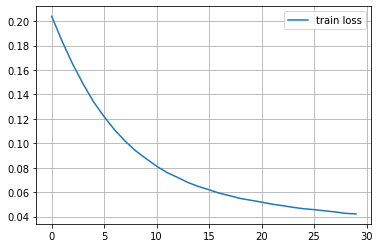

In [29]:
plt.plot(loss_record)
if do_test_loss:
    plt.plot(loss_test_record)
    plt.legend(["train loss", "test loss"])
else:
    plt.legend(["train loss"])
plt.grid(True)

**Change the model from training to evaluation mode** to improve testing performance.

In [30]:
phase = 'test'
# set model to evaluation mode
model.eval()

for epoch in range(10000):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    if phase == 'test':
        loss.backward()
        optimizer.step()
    

In [31]:
# Predict bounding boxes on the test images.
pred_y = model(Variable(torch.Tensor(test_X)).cuda())
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.cpu().numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [32]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.9357116918648997

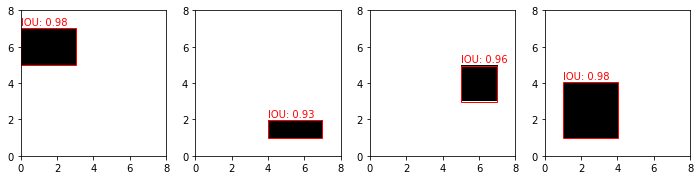

In [33]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs.  **Improve the training setup**, possibly also changing model or optimizer, until you **reach a test IOU above 0.9**.

You can make the changes that move computation to the GPU directly in the cells above as part of 1a.

You may get stuck not achieving test IOU above 0.6. In that case, learn about switching the model to evaluation mode and apply the change above.

## Question 1c:
Why does `eval` mode above have such a significant effect on test performance? Please give a short answer below.

When training the model, a dropout rate of 20% is often used to improve its accuracy by randomly dropping out 20% of the training samples. However, this may not be desirable when testing the network, as it can lead to overfitting and reduced accuracy on the test data.

# Task 2: Use a pretrained model

As mentioned in class, deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll **work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)**, which also provides a ready-made jupyter notebook.

 **2.1.** Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.  
 **2.2.** Perform your own training with the provided setup, fill out the answer to Task 2.2 below.  
 **2.3.** Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type and use the "conv net as fixed feature extractor" approach, fill out the answer to Task 2.3 below.  
 **2.4.** Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Fill out the answer to Task 2.4 below.

## Your solution for Task 2

Before you start, get the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it into a subfolder `data`. The following import is going to attempt loading the image data from there.

Initialize much of the source code from the tutorial notebook located at
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
using [this module](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/tfl_tut.py)

In [34]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from tfl_tut import *

Please study the original notebook and then continue to use its functions as imported from the `tfl_tut` model for convenience to minimize source code copy & paste.

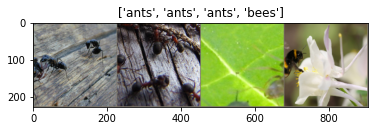

In [36]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

titles = [class_names[x] for x in classes]
image = out

imshow(image, title=titles)

In [37]:
model_conv = models.inception_v3(pretrained=True)

### Answer for Task 2.2

In [38]:
# TODO
model_ft = models.resnet18(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False

in_features = model_ft.fc.in_features
out_features = 2
model_ft.fc = nn.Linear(in_features, out_features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs).to(device)

Epoch 0/29
----------
train Loss: 0.6839 Acc: 0.6270
val Loss: 0.2655 Acc: 0.8954

Epoch 1/29
----------
train Loss: 0.6198 Acc: 0.7418
val Loss: 0.2860 Acc: 0.9085

Epoch 2/29
----------
train Loss: 0.5740 Acc: 0.7582
val Loss: 0.6843 Acc: 0.6928

Epoch 3/29
----------
train Loss: 0.7804 Acc: 0.7336
val Loss: 0.2757 Acc: 0.9085

Epoch 4/29
----------
train Loss: 0.4808 Acc: 0.7951
val Loss: 0.3877 Acc: 0.8693

Epoch 5/29
----------
train Loss: 1.0791 Acc: 0.6762
val Loss: 0.2081 Acc: 0.9477

Epoch 6/29
----------
train Loss: 0.4366 Acc: 0.8115
val Loss: 0.1904 Acc: 0.9477

Epoch 7/29
----------
train Loss: 0.3650 Acc: 0.8443
val Loss: 0.2691 Acc: 0.9216

Epoch 8/29
----------
train Loss: 0.4496 Acc: 0.8238
val Loss: 0.2207 Acc: 0.9412

Epoch 9/29
----------
train Loss: 0.3674 Acc: 0.8566
val Loss: 0.2053 Acc: 0.9412

Epoch 10/29
----------
train Loss: 0.4069 Acc: 0.8402
val Loss: 0.2089 Acc: 0.9412

Epoch 11/29
----------
train Loss: 0.3315 Acc: 0.8443
val Loss: 0.2173 Acc: 0.9346

Ep

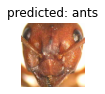

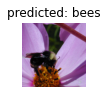

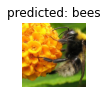

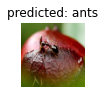

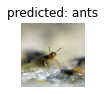

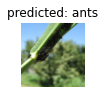

In [39]:
visualize_model(model_ft)

### Answer for Task 2.3

### Hints for this task

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = models.resnet18(pretrained=True)
```
to load VGG16 instead. Set all its parameters to *not* require gradient computation, as shown in the tutorial.

Next, print out the new `model_conv` and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but it works similarily. The last classification step of the VGG model determines the probabilities for each of the 1000 classes of the dataset. Change this layer to identify only 2 classes to distinguish ants and bees as in the example.

To change the structure of some `Sequential` component called ```model_conv.module_name``` and to modify its last layer into a `DifferentLayer` type, you can use this syntax:

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old `model_conv.module_name` with this differently structured version.

In [40]:
# TODO
model_conv = models.vgg16(pretrained=True)

for param in model_conv.parameters():
    param.required_grad = False


# Define the input and output dimensions of the last linear layer
in_features = 4096
out_features = 2

# model_conv.classifier = nn.Sequential(*list(model_conv.classifier.children())[:-1] +
#                                      [nn.Linear(in_features, out_features)])
#The code following has the same output as the code provided in the tutorial, however more readable to me.
#If you would like to use the same code in tutorial for training, uncomment the code block above 
#and comment the following code till 'model_conv.classifier '

# Get the list of child modules of the classifier module
classifier_children = list(model_conv.classifier.children())

# Remove the last linear layer and the softmax function from the list
classifier_children = classifier_children[:-1]

# Add a new linear layer with the specified input and output dimensions to the list
classifier_children.append(nn.Linear(in_features, out_features))

# Create a new Sequential container with the modified list of child modules
model_conv.classifier = nn.Sequential(*classifier_children)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_conv.classifier[-1].parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 30
model_ft = train_model(model_conv, criterion, optimizer_ft, exp_lr_scheduler, num_epochs).to(device)

Epoch 0/29
----------
train Loss: 0.2584 Acc: 0.8730
val Loss: 0.1422 Acc: 0.9477

Epoch 1/29
----------
train Loss: 0.1587 Acc: 0.9344
val Loss: 0.0783 Acc: 0.9673

Epoch 2/29
----------
train Loss: 0.1304 Acc: 0.9344
val Loss: 0.1207 Acc: 0.9477

Epoch 3/29
----------
train Loss: 0.1190 Acc: 0.9426
val Loss: 0.1261 Acc: 0.9542

Epoch 4/29
----------
train Loss: 0.2573 Acc: 0.9057
val Loss: 0.1719 Acc: 0.9608

Epoch 5/29
----------
train Loss: 0.2153 Acc: 0.9426
val Loss: 0.1537 Acc: 0.9412

Epoch 6/29
----------
train Loss: 0.0932 Acc: 0.9672
val Loss: 0.1382 Acc: 0.9477

Epoch 7/29
----------
train Loss: 0.1833 Acc: 0.9344
val Loss: 0.1223 Acc: 0.9477

Epoch 8/29
----------
train Loss: 0.1428 Acc: 0.9549
val Loss: 0.1329 Acc: 0.9608

Epoch 9/29
----------
train Loss: 0.1726 Acc: 0.9426
val Loss: 0.1225 Acc: 0.9477

Epoch 10/29
----------
train Loss: 0.1335 Acc: 0.9590
val Loss: 0.1210 Acc: 0.9477

Epoch 11/29
----------
train Loss: 0.0982 Acc: 0.9713
val Loss: 0.1209 Acc: 0.9477

Ep

### Answer for Task 2.4

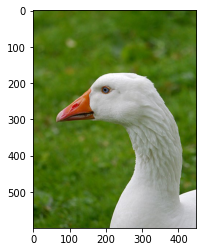

Top 1: goose - Probability: 0.9415
Top 2: white stork - Probability: 0.0300
Top 3: crane - Probability: 0.0150
Top 4: American egret - Probability: 0.0111
Top 5: vulture - Probability: 0.0006


In [43]:
import os
import requests
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Check if imagenet_classes.txt exists in current working directory
if not os.path.exists('imagenet_classes.txt'):
    # Download the file from the URL
    url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
    response = requests.get(url)
    
    # Save the file to the current working directory
    with open('imagenet_classes.txt', 'w') as f:
        f.write(response.text)

# Load the pre-trained model
model = torchvision.models.alexnet(pretrained=True)

# Define the transformation for input image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# Load the input image and apply the transformation
image_path = 'goose.jpeg'
input_image = Image.open(image_path)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

# Plot the input image
plt.imshow(input_image)
plt.show()

# Move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# Evaluate the model and get the predicted class probabilities
with torch.no_grad():
    output = model(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Load the class labels
with open('imagenet_classes.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Get the top 5 predicted classes and their probabilities
top5_prob, top5_indices = torch.topk(probabilities, 5)
top5_classes = [classes[i] for i in top5_indices]

# Display the top 5 predicted classes and their probabilities
for i in range(len(top5_classes)):
    print(f'Top {i+1}: {top5_classes[i]} - Probability: {top5_prob[i].item():.4f}')


Please include the picture so we can view it and its class label in the saved notebook. It's OK, if we don't have the actual image file to reproduce the output.

## Submission

Your submission should be based on a modified version of [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) containing answers to Task 1 and for Task 2, saved with figures including some portions of the transfer learning tutorial notebook in the sections for tasks 2.1 - 2.4.